In [219]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch.nn.utils.rnn import pad_sequence


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
yolo_model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/card_number_detector6/weights/best.pt', source = 'local').to(device)


class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for digits 0-9

        # Dropout layers
        self.dropout1 = nn.Dropout(0.1)  # After first FC layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

digit_cnn = DigitCNN()
digit_cnn.load_state_dict(torch.load('model_checkpoints/model_epoch_30.pth', map_location=device))
digit_cnn.to(device)


class HybridOCR(nn.Module):
    def __init__(self, digit_cnn, img_height, num_classes=10, rnn_hidden_size=128):
        super(HybridOCR, self).__init__()
        
        self.digit_cnn = digit_cnn
        # Freeze the digit CNN weights
        for param in self.digit_cnn.parameters():
            param.requires_grad = False
            
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate the feature dimensions after CNN
        self.feature_height = img_height // 8  # After 3 pooling layers
        self.rnn_hidden_size = rnn_hidden_size
        
        # Bidirectional LSTM
        self.rnn = nn.LSTM(128 * self.feature_height, rnn_hidden_size, 
                          bidirectional=True, batch_first=True)
        
        # Final classification layer
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes + 1)  # +1 for CTC blank
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN Feature Extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Prepare for RNN
        # Change shape from (batch, channels, height, width) to (batch, width, channels * height)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(batch_size, -1, 128 * self.feature_height)
        
        # RNN
        x, _ = self.rnn(x)
        
        # Final classification
        x = self.fc(x)  # Shape: (batch, seq_len, num_classes + 1)
        
        # Apply log softmax for CTC loss
        return F.log_softmax(x, dim=2)

def train_hybrid_model(model, train_loader, val_loader, criterion, optimizer, 
                      num_epochs, device, scheduler=None):
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_char_acc': [], 'train_seq_acc': [],
        'val_loss': [], 'val_char_acc': [], 'val_seq_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_char_accuracies = []
        train_seq_accuracies = []
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Shape: (batch, seq_len, num_classes + 1)
            
            # Prepare CTC loss inputs
            batch_size = outputs.size(0)
            input_lengths = torch.full(size=(batch_size,), 
                                    fill_value=outputs.size(1), 
                                    dtype=torch.long,
                                    device=device)
            
            target_lengths = []
            target_labels = []
            for label in labels:
                valid_label = label[label != -1]  # Remove padding
                target_lengths.append(len(valid_label))
                target_labels.extend(valid_label.tolist())
            
            target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
            target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
            
            # CTC loss expects (seq_len, batch, num_classes)
            outputs = outputs.permute(1, 0, 2)
            
            # Calculate loss
            loss = criterion(outputs, target_labels, input_lengths, target_lengths)
            
            # Calculate accuracy
            predictions = decode_predictions(outputs)
            char_acc, seq_acc = calculate_accuracy(predictions, labels)
            
            # Update metrics
            running_loss += loss.item()
            train_char_accuracies.append(char_acc)
            train_seq_accuracies.append(seq_acc)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Char Acc: {char_acc:.4f}, '
                      f'Seq Acc: {seq_acc:.4f}')
        
        # Calculate and log metrics
        # [Rest of the training loop remains the same...]
        
    return history


# Load the labels from the Excel file
labels_df = pd.read_excel('APS360_Project_Dataset/dataset5/labels.xlsx')

# Assuming your Excel has a single column with labels (1, 2, 3, ...)
# Create a dictionary mapping from numeric labels to corresponding image filenames
image_labels = {f'img_{int(row[0])}': row['card_num'] for _, row in labels_df.iterrows()}

class CreditCardDataset(Dataset):
    def __init__(self, image_dir, labels_dict, yolo_model, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images
            labels_dict (dict): Dictionary mapping image names to their labels
            yolo_model: Loaded YOLO model for credit card number detection
            transform: Optional transform to be applied on the cropped image
        """
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.yolo_model = yolo_model
        self.image_filenames = list(labels_dict.keys())
        
    def preprocess_image(self, image_path):
        """
        Load image and use YOLO to crop the credit card number region
        """
        # Read image using cv2
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image at {image_path}")
        
        # Get YOLO predictions
        results = self.yolo_model(original_image)
        
        # Extract bounding box coordinates
        if len(results.xyxy[0]) > 0:
            # Get the detection with highest confidence
            detection = results.xyxy[0][0]  # [x1, y1, x2, y2, confidence, class]
            x1, y1, x2, y2 = map(int, detection[:4])
            
            # Crop the image
            cropped_image = original_image[y1:y2, x1:x2]
            
            
            
            # Convert to grayscale
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
            
            # Convert to PIL Image
            pil_image = Image.fromarray(gray_image)
            
            return pil_image
        else:
            # If no detection, return the original image converted to grayscale
            print(f"No detection found for {image_path}, using full image")
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
            pil_image = Image.fromarray(gray_image)
            return pil_image

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Returns a tuple (image, label) where label is a list of integers
        """
        try:
            # Get image filename
            img_name = self.image_filenames[idx]
            image_path = os.path.join(self.image_dir, img_name + '.png')
            
            # Process image with YOLO and get cropped region
            image = self.preprocess_image(image_path)
            
            # Apply transforms if any
            if self.transform:
                image = self.transform(image)
            
            # Convert label from integer to list of integers
            label = [int(digit) for digit in str(self.labels_dict[img_name])]
            
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error processing image {img_name}: {str(e)}")
            raise e

# Optional: Function to visualize the preprocessing
def visualize_preprocessing(dataset, index):
    """
    Visualize the original image, YOLO detection, and final processed image
    """
    import matplotlib.pyplot as plt
    
    # Get original image path
    img_name = dataset.image_filenames[index]
    image_path = os.path.join(dataset.image_dir, img_name + '.png')
    
    # Read original image
    original_image = cv2.imread(image_path)
    
    # Get YOLO predictions
    results = dataset.yolo_model(original_image)
    
    # Create a copy for drawing
    detection_image = original_image.copy()
    
    # Draw detection box
    if len(results.xyxy[0]) > 0:
        detection = results.xyxy[0][0]
        x1, y1, x2, y2 = map(int, detection[:4])
        cv2.rectangle(detection_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Get processed image
    processed_image, label = dataset[index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(detection_image)
    axes[1].set_title('YOLO Detection')
    axes[1].axis('off')
    
    # Convert tensor to numpy for visualization
    processed_np = processed_image.squeeze().numpy()
    axes[2].imshow(processed_np, cmap='gray')
    axes[2].set_title('Processed Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Label: {''.join(map(str, label.tolist()))}")

# Directory where your images are located
image_dir = 'APS360_Project_Dataset/dataset5/img'

# Define any transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((32, 128)),  # Resize to your model's expected input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


# Create datasets with YOLO model
train_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=train_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

val_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=val_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

test_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=test_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    
    # Pad labels to the maximum length in the batch and convert to tensor
    padded_labels = pad_sequence([torch.tensor(label, dtype=torch.long) for label in labels], 
                                 batch_first=True, padding_value=-1)
    
    # Stack images into a single tensor
    images = torch.stack(images, dim=0)
    
    return images, padded_labels

# Update the DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn =custom_collate_fn)


# Initialize the hybrid model
img_height = 32  # Based on the transform resize height
hybrid_model = HybridOCR(digit_cnn=digit_cnn, img_height=img_height).to(device)

# Initialize CTC loss
criterion = nn.CTCLoss(blank=0, reduction='mean')

# Initialize optimizer with learning rate scheduling
initial_lr = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, hybrid_model.parameters()), 
                      lr=initial_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, 
                             verbose=True, min_lr=1e-6)

def decode_predictions(outputs):
    """
    Decode the model outputs into digit sequences
    Args:
        outputs: Model outputs after log_softmax (T, B, C)
    Returns:
        List of predicted number sequences
    """
    # Convert to probabilities and get best indices
    _, max_indices = torch.max(outputs.transpose(0, 1), 2)
    
    # Convert to numpy for processing
    indices = max_indices.cpu().numpy()
    
    # Process each sequence in the batch
    decoded_sequences = []
    for sequence in indices:
        # Remove duplicates and blanks (0)
        current_digit = -1
        current_sequence = []
        
        for digit in sequence:
            if digit != 0 and digit != current_digit:  # Exclude blanks and duplicates
                current_sequence.append(digit)
                current_digit = digit
        
        decoded_sequences.append(current_sequence)
    
    return decoded_sequences

def calculate_accuracy(predictions, targets):
    """
    Calculate character and sequence level accuracy
    Args:
        predictions: List of predicted sequences
        targets: Tensor of target sequences (batch_size, max_length)
    Returns:
        (character_accuracy, sequence_accuracy)
    """
    correct_chars = 0
    total_chars = 0
    correct_sequences = 0
    total_sequences = 0
    
    for pred, target in zip(predictions, targets):
        # Convert target tensor to list, removing padding
        target_seq = [int(x) for x in target if x != 0]
        
        # Character level accuracy
        min_len = min(len(pred), len(target_seq))
        correct_chars += sum(1 for i in range(min_len) if pred[i] == target_seq[i])
        total_chars += max(len(pred), len(target_seq))
        
        # Sequence level accuracy
        if len(pred) == len(target_seq) and all(p == t for p, t in zip(pred, target_seq)):
            correct_sequences += 1
        total_sequences += 1
    
    char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
    seq_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    
    return char_accuracy, seq_accuracy

# Training configuration
num_epochs = 10
best_val_accuracy = 0.0

print("Starting training...")
print(f"Training device: {device}")
print(f"Initial learning rate: {initial_lr}")
print(f"Number of epochs: {num_epochs}")

# Start training
history = train_hybrid_model(
    model=hybrid_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler
)

# Save the final model
torch.save({
    'model_state_dict': hybrid_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history,
    'final_ensemble_weights': hybrid_model.get_ensemble_weights()
}, 'final_hybrid_model.pth')

print("Training completed!")
print(f"Final ensemble weights: {hybrid_model.get_ensemble_weights()}")

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot character accuracy
    ax2.plot(history['train_char_acc'], label='Train')
    ax2.plot(history['val_char_acc'], label='Validation')
    ax2.set_title('Character Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Plot sequence accuracy
    ax3.plot(history['train_seq_acc'], label='Train')
    ax3.plot(history['val_seq_acc'], label='Validation')
    ax3.set_title('Sequence Accuracy Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    
    # Plot ensemble weights
    weights = np.array(history['ensemble_weights'])
    ax4.plot(weights[:, 0], label='CRNN Weight')
    ax4.plot(weights[:, 1], label='DigitCNN Weight')
    ax4.set_title('Ensemble Weights Over Time')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Weight')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


YOLOv5 🚀 2024-11-1 Python-3.9.13 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Starting training...
Training device: cpu
Initial learning rate: 0.001
Number of epochs: 10
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
Epoch [1/10], Batch [0/2], Loss: inf, Char Acc: 0.0301, Seq Acc: 0.0000
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
Epoch [2/10], Batch [0/2], Loss: nan, Char Acc: 0.0000, Seq Acc: 0.0000
Epoch [3/10], Batch [0/2], Loss: nan, Char Acc: 0.0000, Seq Acc: 0.0000
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
Epoch [4/10], Batch [0/2], Loss: nan, Char Acc: 0.0000, Seq Acc: 0.0000
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
Epoch [5/10], Batch [0/2], Loss: nan, Char Acc: 0.0000, Seq Acc: 0.0000
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image
Epoch [6/10], Batch 

AttributeError: 'HybridOCR' object has no attribute 'get_ensemble_weights'

No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image


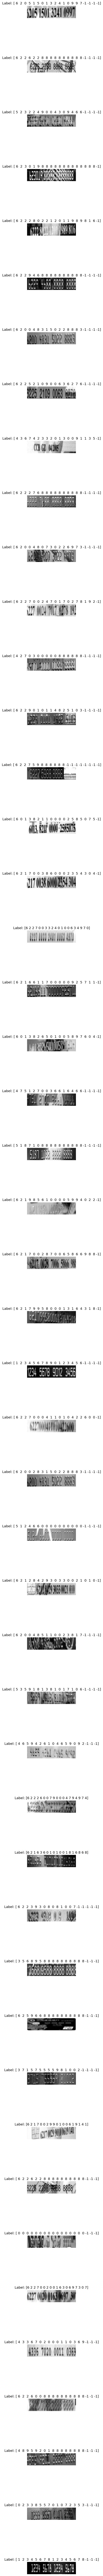

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline


# Function to display images in a grid
def show_images(images, labels, n_cols=4):
    n_images = len(images)
    n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    
    plt.figure(figsize=(3, n_rows * 3))
    
    for idx in range(n_images):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0), cmap='gray')  # Convert to (H, W, C) format
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')  # Hide axes
        
    plt.tight_layout()
    plt.show()

# Iterate through the train_loader to collect all images
all_images = []
all_labels = []

for inputs, targets in train_loader:
    all_images.extend(inputs)  # Extend the list with the batch of images
    all_labels.extend(targets.numpy())  # Extend the list with the batch of labels

# Show all images in the training set
show_images(all_images, all_labels, n_cols=1)

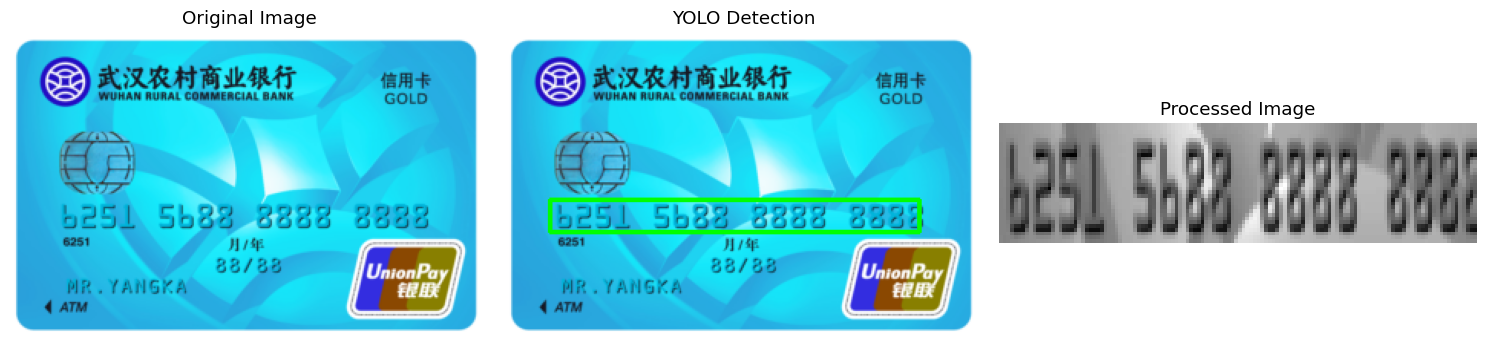

Label: 625156888888888


In [218]:
visualize_preprocessing(test_dataset,1)